In [66]:
import numpy as np
import matplotlib.pyplot as plt

In [159]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 8-1 합성곱 연산
합성곱(convolutiaon) 연산 + 교차 상관(cross-correlation) 연산

## 합성곱 연산
$$x * w^r$$

### 합성곱 연산 구현

In [68]:
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

In [69]:
w_r = np.flip(w)
# w_r = w[::-1]
print(w_r)

[3 5 1 2]


In [70]:
# 넘파이로 합성곱 수행
for i in range(6):
    print(np.dot(x[i:i+4], w_r))


63
48
49
28
21
20


In [71]:
# 싸이파이로 합성곱 수행
from scipy.signal import convolve
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

## 합성곱 신경망은 진짜 합성곱을 사용하지 않는다.
대부분의 딥러닝 패키지들은 합성곱 신경망을 만들 때 교차 상관을 사용한다.

교차 상관
$$x*w$$

In [72]:
# 싸이파이로 교차 상관 수행
from scipy.signal import correlate
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

### 교차 상관 이유
가중치 배열은 무작위로 초기화되기 때문에 합성곱 처럼 배열을 뒤집어서 계산하는 것과 교차 상관 처럼 그대로 계산하는 것과의 차이점이 없다.

## 패딩, 스트라이드
* 패딩(padding): 원본 배열 양 끝에 빈원소 추가
* 스트라이드(stride): 미끄러지는 배열의 간격

### valid padding
앞에서 mode='valid'라고 지정했다. 이는 valid padding을 지정한 것이다. 
* valid padding: 원본 배열에 패딩을 추가하지 않고 교차 상관을 수행
* valid padding은 교차 상관을 수행해서 얻은 결과 배열의 크기가 원본 배열보다 작다. 원본 배열의 각 원소가 연산에 참여하는 정도가 다른 것 특징이다. 

### full padding
풀 패딩(full padding)은 원본 배열 원소의 연산 참여도를 동일하게 만든다.
* 적절한 개수의 제로 패딩(zero padding)을 추가한다.
* full padding으로 교차 상관을 수행하여 얻은 결과 배열의 크기는 원본 배열보다 크다.

In [73]:
# full padding 예시
correlate(x, w, mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

### same padding
* same padding은 출력 배열의 길이가 원본 배열의 길이와 같아지도록 제로 패딩을 추가한다.

In [74]:
# same padding
correlate(x, w, mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

### stride
스트라이드를 k로 지정시 k칸씩 미끄러지며 연산 수행

## 2차원 배열 합성곱
원본 배열의 왼쪽 모서리 끝에 미끄러지는 배열을 맞춘 다음 수행

In [75]:
# 2차원 배열 합성곱
# valid padding
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
w = np.array([[2, 0],
              [0, 0]])

from scipy.signal import correlate2d

correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [76]:
# same padding - 오른쪽 모서리에 패딩이 추가된다.
correlate2d(x, w, mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

## 텐서플로 합성곱
* 원본 배열 - 입력
* 미끄러지는 배열 - 가중치
  

2차원 합성곱 수행 - conv2d()
* 보통 4차원 배열을 입력으로 받는다.
* ex) (2, 3, 3, 3) - 배치 2, 샘플 높이 3, 샘플 너비 3,  컬러채널(RGB) 3
* 가중치는 (가중치 높이, 가중치 너비, 채널, 가중치 개수)
* same padding 적용시 (입력 배치, 입력 높이, 입력 너비, 가중치 개수)

In [77]:
# 4차원 합성곱
import tensorflow as tf
with tf.device('/gpu:0'):
    x_4d = x.astype(np.float).reshape(1, 3, 3, 1)
    w_4d = w.reshape(2, 2, 1, 1)

In [78]:
with tf.device('/gpu:0'):
    c_cout = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')

In [79]:
c_cout.numpy().reshape(3,3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

# 8-2 풀링 연산
풀링(pooling): 특성 맵을 스캔하며 최댓값을 고르거나 평균값을 계산하는 것

## 최대 풀링(max pooling)
* 특성 맵 위를 스캔하며 최댓값을 고른다.
* 가장 큰 특징을 유지시킨다.(이미지 분류 작업에 잘 맞다.)

## 평균 풀링(average pooling)
* 특성 맴 위를 스캔하며 평균을 낸다.
* 가장 큰 특성의 값을 상쇄시킨다.

## max, average pooling

In [80]:
x = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])
x = x.reshape(1, 4, 4, 1)

In [81]:
p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')

In [82]:
p_out.numpy().reshape(2, 2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

풀링층 통과 전후의 배치 크기와 채널 크기는 동일하다.

# 8-3 합성곱 신경망의 구조

## ReLU 함수
* 이전엔 은닉층의 활성화 함수로 시그모이드 함수를 사용, 출력층은 시그모이드(이진분류), 소프트맥스(다중분류) 사용
* ReLU 함수: 주로 합성곱층에 적용되는 활성화 함수
$$y=
\begin{cases}
x & (x > 0) \\
0 & (x \leq 0)
\end{cases}
$$

In [83]:
# ReLU 함수 구현
def relu(x):
    return np.maximum(x, 0)

In [84]:
x = np.array([-1, 2, -3, 4, -5])
relu(x)

array([0, 2, 0, 4, 0])

In [85]:
r_out = tf.nn.relu(x)
r_out.numpy()

array([0, 2, 0, 4, 0])

## ReLU함수의 도함수
$$y=
\begin{cases}
1 & (x > 0) \\
0 & (x \leq 0)
\end{cases}
$$

# 8-4 합성곱 신경망 만들어 훈련

In [138]:
class ConvolutionNetwork():

    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels
        self.kernel_size = 3
        self.optimizer = None
        self.conv_w = None
        self.conv_b = None
        self.units = units
        self.batch_size = batch_size
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate

    def forpass(self, x):
        # 3x3 합성곱 연산 수행
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        # relu 함수 적용
        r_out = tf.nn.relu(c_out)
        # 2x2 최대 풀링 적용
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 배치 차원을 제외, 출력 펴기
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1
        a1 = tf.nn.relu(z1)
        z2 = tf.matmul(a1, self.w2) + self.b2
        return z2

    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)
        self.w2 = tf.Variable(g((self.units, n_classes)))
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        
        for i in range(epochs):
            print('에포크', i)

            batch_losses = []
            i = 1
            for x_batch, y_batch, in self.gen_batch(x, y):
                print(f'진행률: {(i / (len(x) / self.batch_size)) * 100:-4.0f}%', end='')
                self.training(x_batch, y_batch)
                batch_losses.append(self.get_loss(x_batch, y_batch))
                i += 1
                print('\r', end='')
            print()
            self.losses.append(np.mean(batch_losses))
            self.val_losses.append(self.get_loss(x_val, y_val))

    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i+1)
            yield x[start:end], y[start:end]

    def training(self, x, y):
        m = len(x)
        with tf.GradientTape() as tape:
            z = self.forpass(x)
            # 손실 함수 계산
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)

        weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]
        # 가중치에 대한 그레디언트 계산
        grads = tape.gradient(loss, weights_list)
        # 가중치 업데이트
        self.optimizer.apply_gradients(zip(grads, weights_list))

    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z.numpy(), axis=1)
    
    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

In [147]:
# 데이터 셋 불러오기
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [148]:
# 데이터셋 나누기
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                        stratify=y_train_all, test_size=0.2,
                                        random_state=42)

In [149]:
# 원-핫 인코딩
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [150]:
# 입력 데이터 준비
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [151]:
print(x_train.shape, x_val.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1)


In [152]:
# 입력 데이터 표준화
x_train = x_train / 255
x_val = x_val / 255

In [154]:
# 모델 훈련
with tf.device('/GPU:0'):
    cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
    cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0
진행률:  100%
에포크 1
진행률:  100%
에포크 2
진행률:  100%
에포크 3
진행률:  100%
에포크 4
진행률:  100%
에포크 5
진행률:  100%
에포크 6
진행률:  100%
에포크 7
진행률:  100%
에포크 8
진행률:  100%
에포크 9
진행률:  100%
에포크 10
진행률:  100%
에포크 11
진행률:  100%
에포크 12
진행률:  100%
에포크 13
진행률:  100%
에포크 14
진행률:  100%
에포크 15
진행률:  100%
에포크 16
진행률:  100%
에포크 17
진행률:  100%
에포크 18
진행률:  100%
에포크 19
진행률:  100%


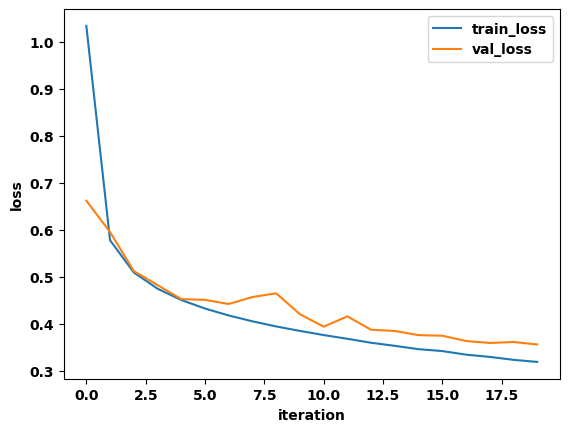

In [155]:
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [156]:
cn.score(x_val, y_val_encoded)

0.87625

# 8-5 케라스로 합성곱 신경망 만들기

In [157]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [158]:
# 합성곱층 쌓기
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))

In [160]:
# 풀링층 쌓기
conv1.add(MaxPool2D((2, 2))) # padding 기본값: valid

In [161]:
# 특성 맵 펼치기
conv1.add(Flatten())

In [162]:
# 완전 연결층 쌓기
conv1.add(Dense(100, activation='relu'))
conv1.add(Dense(10, activation='softmax'))

In [163]:
# 모델 구조 살펴보기
conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [164]:
# 합성곱 신경망 모델 훈련
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [165]:
# adam(Adaptive Moment Estimation) 옵티마이저: 정응적 학습률 알고리즘
history = conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))


Epoch 1/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4494 - accuracy: 0.8411 - val_loss: 0.3252 - val_accuracy: 0.8842
Epoch 2/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3066 - accuracy: 0.8911 - val_loss: 0.2984 - val_accuracy: 0.8946
Epoch 3/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2588 - accuracy: 0.9067 - val_loss: 0.2841 - val_accuracy: 0.8979
Epoch 4/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2291 - accuracy: 0.9167 - val_loss: 0.2630 - val_accuracy: 0.9097
Epoch 5/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.1986 - accuracy: 0.9276 - val_loss: 0.2592 - val_accuracy: 0.9123
Epoch 6/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1810 - accuracy: 0.9326 - val_loss: 0.2753 - val_accuracy: 0.9053
Epoch 7/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1609 - accuracy: 0.9394 - val_loss: 0.2654 - val_accuracy

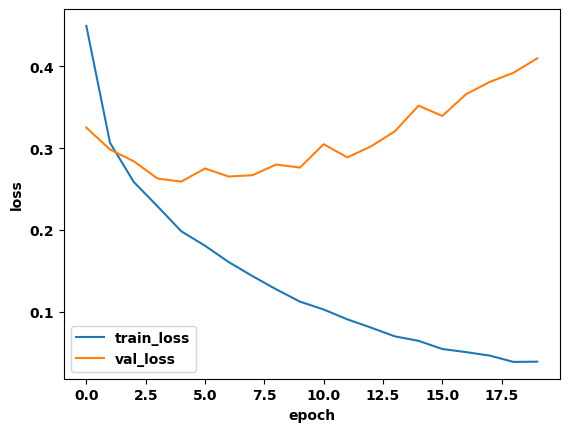

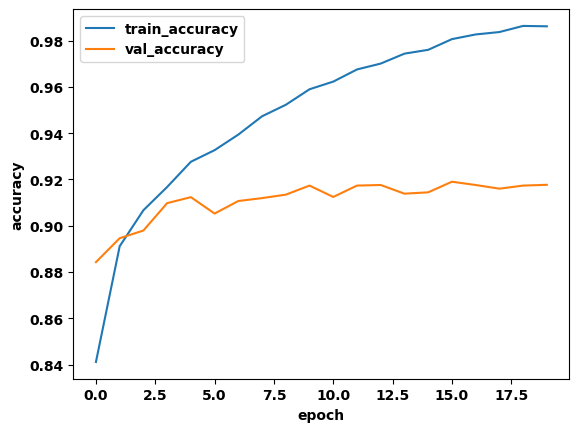

In [166]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

정확도와 손실을 그래프로 그려보니 몇 번의 에포크 만에 검증 손실이 크게 증가했다. 이는 과대적합이 일찍 발생했음을 의미한다.

## 드롭아웃
* 신경망에서 과대적합을 줄이는 방법 중 1하나
* 무작위로 뉴런을 비활성화 시킨다. -> 특정 뉴런에 과도하게 의존하여 훈련하는 것을 막는다. -> 일반화 성능이 좋아진다.
* 모델을 훈련시킬때만 쓰기 때문에 테스트와 실전의 출력값을 드롭아웃 비율만큼 낮춰야 한다.

## 드롭아웃이 적용된 합성곱 신경망 구현
* 간단히 Dropout 클래스 추가

In [167]:
from tensorflow.keras.layers import Dropout

conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPool2D((2, 2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

In [168]:
conv2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [169]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = conv2.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5260 - accuracy: 0.8083 - val_loss: 0.3670 - val_accuracy: 0.8643
Epoch 2/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3728 - accuracy: 0.8622 - val_loss: 0.3018 - val_accuracy: 0.8928
Epoch 3/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3304 - accuracy: 0.8781 - val_loss: 0.2819 - val_accuracy: 0.9003
Epoch 4/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3036 - accuracy: 0.8878 - val_loss: 0.2700 - val_accuracy: 0.9022
Epoch 5/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2868 - accuracy: 0.8926 - val_loss: 0.2564 - val_accuracy: 0.9062
Epoch 6/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2704 - accuracy: 0.8982 - val_loss: 0.2492 - val_accuracy: 0.9078
Epoch 7/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2590 - accuracy: 0.9036 - val_loss: 0.2547 - val_accuracy:

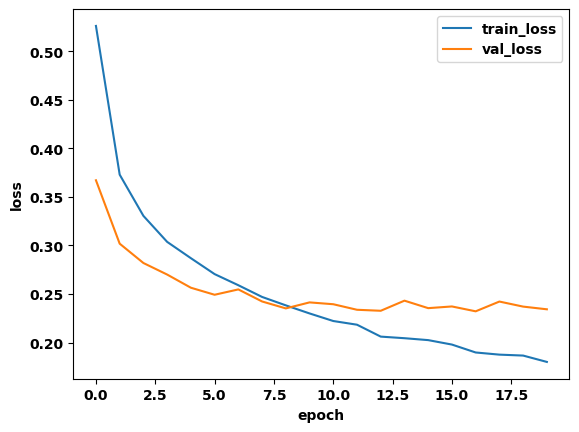

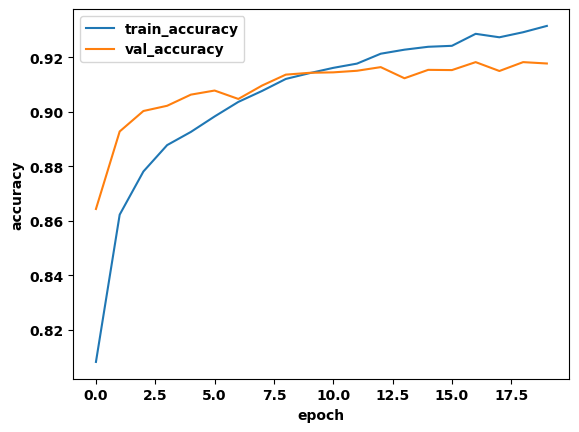

In [170]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [175]:
np.sum(np.argmax(conv2.predict(x_val), axis=1) == y_val) / len(x_val)

0.9176666666666666